In [1]:
"""
データ取得
ChEMBLとBindingDBのデータを取得し、EC50の値を取得する
"""
import pandas as pd
import numpy as np

ChEMBL_df = pd.read_csv("./data/ChEMBL.tsv", sep='\t')
ChEMBL_df = ChEMBL_df.dropna(subset=['Standard Relation'])
ChEMBL_df = ChEMBL_df.dropna(subset=['Standard Value'])
ChEMBL_df = ChEMBL_df[ChEMBL_df['Standard Relation'].str.contains("'='")]
ChEMBL_df = ChEMBL_df[ChEMBL_df['Standard Units'].str.contains('nM')]

BindingDB_df = pd.read_csv("./data/BindingDB.tsv", sep='\t')
BindingDB_df = BindingDB_df.dropna(subset=['EC50 (nM)'])
BindingDB_df = BindingDB_df[~BindingDB_df['EC50 (nM)'].str.contains('<|>')]
BindingDB_df['EC50 (nM)'] = BindingDB_df['EC50 (nM)'].astype(float)

# 両データフレームを結合
ChEMBL_df = ChEMBL_df[['Smiles', 'Standard Value']]
ChEMBL_df = ChEMBL_df.rename(columns={'Standard Value': 'EC50 (nM)'})
BindingDB_df = BindingDB_df[['Ligand SMILES', 'EC50 (nM)']]
BindingDB_df = BindingDB_df.rename(columns={'Ligand SMILES': 'Smiles'})

df = pd.concat([ChEMBL_df, BindingDB_df])

# 重複を削除
df = df.drop_duplicates(subset='Smiles')
print(df['EC50 (nM)'].describe())

df.to_csv('EC50.csv', index=False)

# 1000nM以下を1、それ以外を0に変換
# df['EC50 (nM)'] = df['EC50 (nM)'].apply(lambda x: 1 if x <= 1000 else 0)
# print(df['EC50 (nM)'].describe())

count    1.773000e+03
mean     4.483144e+03
std      4.856441e+04
min      0.000000e+00
25%      3.610000e+01
50%      2.330000e+02
75%      1.230000e+03
max      1.900000e+06
Name: EC50 (nM), dtype: float64


In [2]:
"""
データ前処理
- EC50は小さいほど強いので逆数を取り、標準化
"""

# EC50が1000以下のものを1, 1000以上のものを0にする
df['EC50 (nM)'] = df['EC50 (nM)'].apply(lambda x: 1 if x <= 500 else 0)

print(df['EC50 (nM)'].describe())

# EC50の逆数を取り、標準化
# df['EC50 (nM)'] = 1 / df['EC50 (nM)']

# 標準化を行う場合
# from sklearn.preprocessing import StandardScaler
# df['EC50 (nM)'] = StandardScaler().fit_transform(df['EC50 (nM)'].values.reshape(-1, 1))

# min-max scalingを行う場合
# from sklearn.preprocessing import MinMaxScaler
# df['EC50 (nM)'] = df['EC50 (nM)'].astype(np.float32)
# df['EC50 (nM)'] = MinMaxScaler().fit_transform(df['EC50 (nM)'].values.reshape(-1, 1))

# print(df['EC50 (nM)'].describe())

count    1773.000000
mean        0.624929
std         0.484278
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: EC50 (nM), dtype: float64


In [3]:
"""
フィンガープリント作成
"""
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.AtomPairs import Sheridan

smiles_list = df['Smiles'].tolist()
# maccs = [AllChem.GetMACCSKeysFingerprint(Chem.MolFromSmiles(smiles)) for smiles in smiles_list]
# fp_df = pd.DataFrame(np.array(maccs, int))
ecfp = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 4, 4096) for smiles in smiles_list]
# fp_df = pd.concat([fp_df, pd.DataFrame(np.array(ecfp, int))], axis=1)
fp_df = pd.DataFrame(np.array(ecfp, int))

# 分散が0の変数を削除
fp_df = fp_df.loc[:, fp_df.var() != 0]

# 相関係数が高い変数を削除 -> 一つの構造による重複した寄与を削除
from dcekit.variable_selection import search_highly_correlated_variables
threshold_of_r = 0.95 #変数選択するときの相関係数の絶対値の閾値
corr_var = search_highly_correlated_variables(fp_df, threshold_of_r)
fp_df.drop(fp_df.columns[corr_var], axis=1, inplace=True)

# 5分子以上で出現するフィンガープリントのみを残す
fp_df = fp_df.loc[:, fp_df.sum() >= 5]

[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerator
[16:26:57] DEPRECATION WARNING: please use MorganGenerat

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


In [4]:
"""
学習
"""
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print(fp_df.shape)

X = fp_df
y = df['EC50 (nM)'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# borutaによる変数選択
from boruta import BorutaPy

corr_list = []
for n in range(10000):
    shadow_features = np.random.rand(X_train.shape[0]).T
    corr = np.corrcoef(X_train, shadow_features,rowvar=False)[-1]
    corr = abs(corr[corr < 0.95])
    corr_list.append(corr.max())
    corr_array = np.array(corr_list)
    perc = 100 * (1-corr_array.max())

rf = RandomForestRegressor(n_estimators=100, random_state=0)

feat_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=0,
    alpha=0.05,
    max_iter=50,
    perc=perc,
    random_state=0
)

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

feat_selector.fit(X_train.values, y_train.values)

X_train_selected = X_train.iloc[:, feat_selector.support_]
X_test_selected = X_test.iloc[:, feat_selector.support_]

print(X_train_selected.shape)

(1773, 3203)
(1418, 98)


In [5]:
# モデルの学習
rf.fit(X_train_selected, y_train)

# 2値分類の評価
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = rf.predict(X_test_selected)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.8225352112676056
[[106  37]
 [ 26 186]]
              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77       143
         1.0       0.83      0.88      0.86       212

    accuracy                           0.82       355
   macro avg       0.82      0.81      0.81       355
weighted avg       0.82      0.82      0.82       355



In [6]:
"""
予測したい構造のフィンガープリントを作成
"""
from rdkit.Chem import AllChem

def generate_peptides(n):
    print("Generating peptides...")

    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    peptides = []

    def build_peptide(current_peptide):
        if len(current_peptide) == n:
            peptides.append(current_peptide)
            return
        for amino_acid in amino_acids:
            build_peptide(current_peptide + amino_acid)

    build_peptide('')

    print(f"Generated {len(peptides)} peptides.")
    
    return peptides

peptides = generate_peptides(3)
morgan_peptides = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromFASTA(peptide), 4, 4096) for peptide in peptides]
morgan_peptides_df = pd.DataFrame(np.array(morgan_peptides, int))

# fp_dfと同じ変数を持つようにする
morgan_peptides_df = morgan_peptides_df.loc[:, morgan_peptides_df.columns.isin(fp_df.columns)]

# モデルによる予測
morgan_peptides_df = morgan_peptides_df.iloc[:, feat_selector.support_]

result = rf.predict(morgan_peptides_df)
print(result)

Generating peptides...
Generated 8000 peptides.


[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerator
[17:44:38] DEPRECATION WARNING: please use MorganGenerat

[0.90865385 0.82745726 0.82745726 ... 0.90865385 0.90865385 0.90865385]


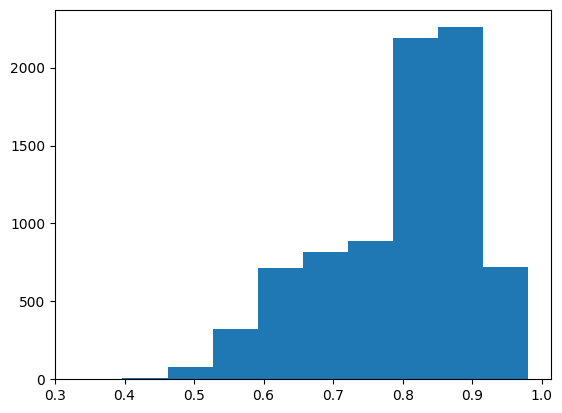

In [7]:
# resultを描画
import matplotlib.pyplot as plt

plt.hist(result)
plt.show()

In [8]:
# resultとペプチドの対応を表示
result_df = pd.DataFrame({'peptide': peptides, 'result': result})
# 高い順にソート
result_df = result_df.sort_values('result', ascending=False)

result_df.to_csv('result.csv', index=False)

In [28]:
# result.csvから上位ペプチドを取得
import pandas as pd

result_df = pd.read_csv('result.csv')
high_score_peptides = result_df["peptide"].values[:9].tolist()

from rdkit import Chem
from rdkit.Chem import Draw

rdkit_high_score_peptides = [Chem.MolFromFASTA(peptide) for peptide in high_score_peptides]
Draw.MolsToGridImage(rdkit_high_score_peptides, molsPerRow=3, legends=high_score_peptides).show()


<class 'list'>
